In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic
from scipy.special import logit

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


# 1. Experiments and Paths

In [2]:
experiment_name = "tramdagpaper_exp6_1_linearDGP_ls_9"   ## <--- set experiment name
seed=42
np.random.seed(seed)

DATA_PATH = "/home/bule/TramDag/data"
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
os.makedirs(EXPERIMENT_DIR,exist_ok=True)

# 2.  Data

- same experiment as in https://arxiv.org/pdf/2503.16206 6.1 Conitnous Case
- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

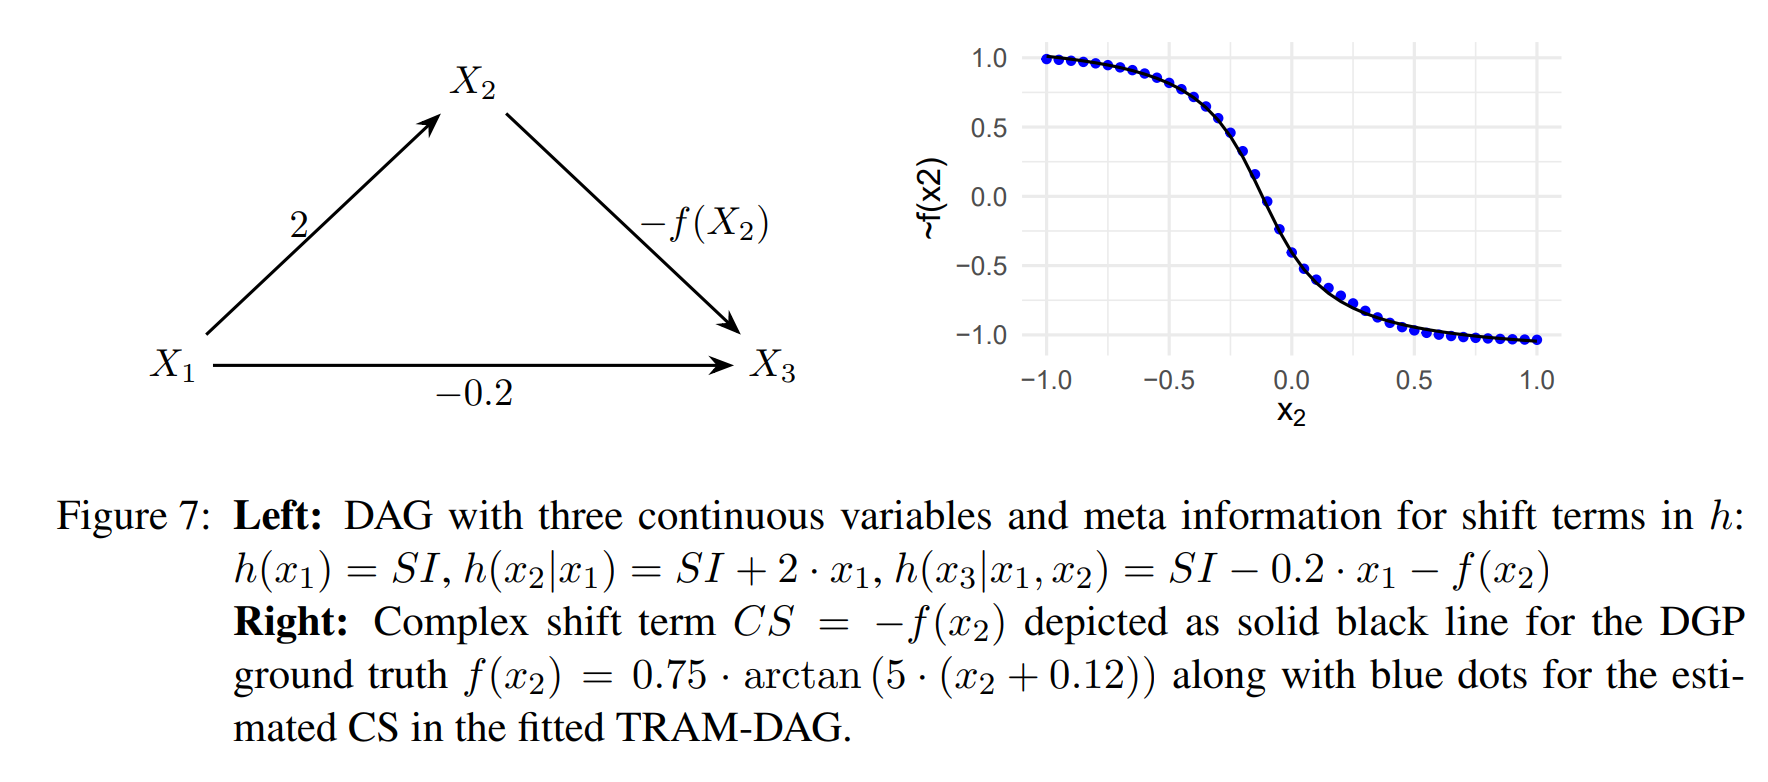

they made 3 experiments:
1. Linear-shift DGP and linear-shift model 
2. Complex-shift DGP and complex-shift model
3. Linear-shift DGP and complex-shift model 

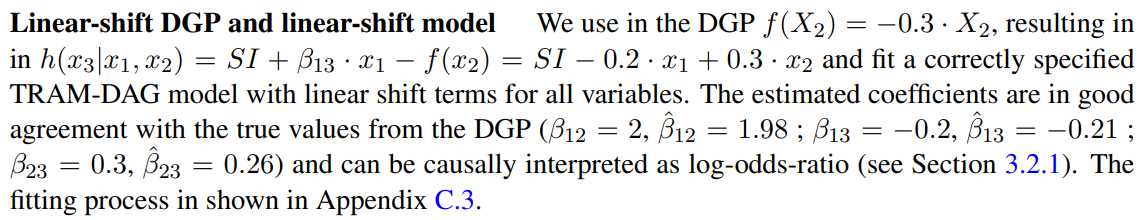

Setting Seed: 42
Loaded data from /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_9/tramdagpaper_exp6_1_linearDGP_ls_9.csv


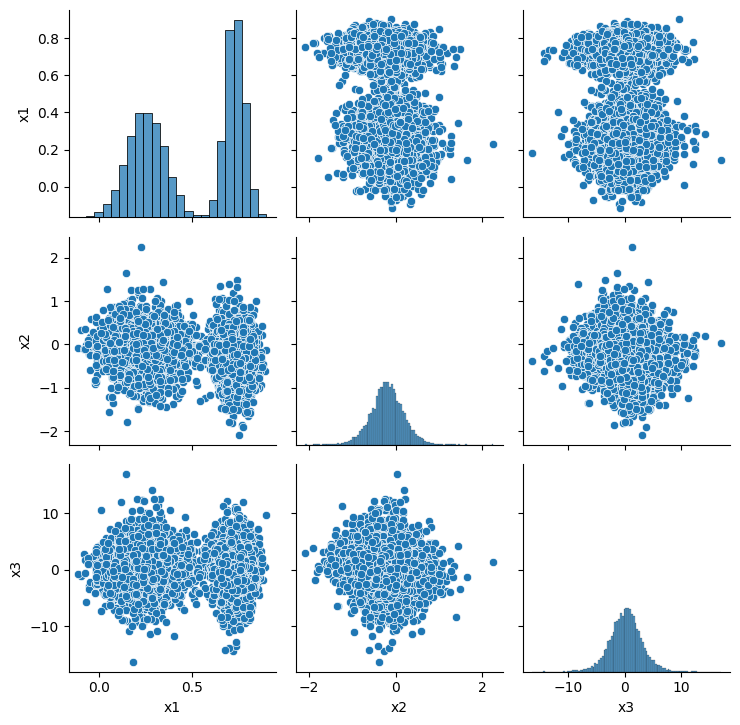

In [3]:
# 1. Linear-shift DGP and linear-shift model 
def f(x):
    return -0.3*x  

def dgp(n_obs, doX=[None, None, None], seed=-1):
    if seed > 0:
        np.random.seed(seed)
        print(f"Setting Seed: {seed}")
    
    # Generate x1 from a 2-component GMM
    
    # h(x1)= SI 
    
    
    if doX[0] is None:
        x1_A = np.random.normal(0.25, 0.1, n_obs)
        x1_B = np.random.normal(0.73, 0.05, n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, x1_A, x1_B)
    else:
        x1 = np.full(n_obs, doX[0])



    # Fz(z)=Fy(y)
    # Fz(h(y|x))=Fy(y)    | z= h(y|x)

    # Generate x2
    
    # h(x2|x1)= Bernsteinpol(x2) + beta2 * x1        | bernsteinpol is just linearized assumed with a constant factor say 0.42
    # h(x2|x1)= 0.42*x2 + beta2 * x1                 | replace h(x2|x1) with z
    # z       = 0.42*x2 + beta2 * x1                 | reformulate to x2
    # x2      = (z-beta2 * x1 )/0.42                 | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x2      = (z-beta2 * x1 )/0.42                 | set beta = 2 (on the edge of the graph)
    # x2      = (z-2 * x1 )/0.42                     |
    
    if doX[1] is None:
        u2 = np.random.uniform(size=n_obs)
        z2 = logit(u2)
        x2 = (z2 - 2 * x1) / 5#   0.42  in the trainagle strucutred cont last line is 5 for SI
    else:
        x2 = np.full(n_obs, doX[1])

    # Generate x3
    
    # h(x3|x2,x1)= Bernsteinpol(x3) + beta3 * x1 -f(X2)        | bernsteinpol is just linearized assumed with a constant factor say 0.63
    # h(x3|x2,x1)= 0.63*x3 + beta3 * x1          - f(X2)        | replace h(x2|x1) with z
    # z3          = 0.63*x3 + beta3 * x1          - f(X2)        | reformulate to x2
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | sample z from standart logistic via uniform and logit(np.random.uniform(size=n_obs))
    # x3         = (z3-beta3 * x1 +f(X2))/0.63                   | set beta = -0.2 (on the edge of the graph)
    # x3         = (z3+0.2 * x1   +f(X2))/0.63                   | 

    
    if doX[2] is None:
        u3 = np.random.uniform(size=n_obs)
        z3 = logit(u3)
        x3 = (z3 + 0.2 * x1 + f(x2)) / 0.63
    else:
        x3 = np.full(n_obs, doX[2])

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
    return df

n_obs=40_000

df = dgp(n_obs=n_obs, seed=42)

EXP_DATA_PATH=os.path.join(EXPERIMENT_DIR, f"{experiment_name}.csv")


if not os.path.exists(EXP_DATA_PATH):
    df = dgp(n_obs=n_obs)

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)

else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")


sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

## 2.1 train test split

In [4]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


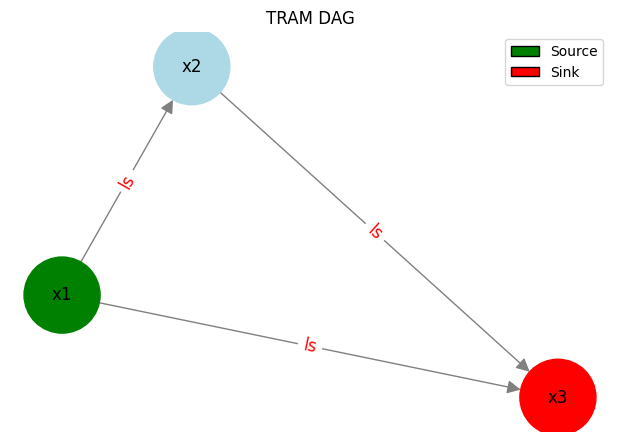

In [5]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 

# TODO support for interactions in CI model eg CI_1

# Example 1 dgp tramdag paper  3x3: 
data_type={'x1':'cont','x2':'cont','x3':'cont'}  # continous , images , ordinal
adj_matrix = np.array([
    [ "0", "ls", "ls"],  # A -> B (cs), A -> C (ls)
    [ "0", "0", "ls"],  # B -> D (ls)
    [ "0", "0", "0"],  # C -> D (cs)
], object)

# its also possible to have ci11 and ci12 etc to inlcude multiple varibales for a network for the intercept. aswell as for cs name it with ci11 ci12

plot_seed=5
plot_dag(adj_matrix,data_type, seed=plot_seed)

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

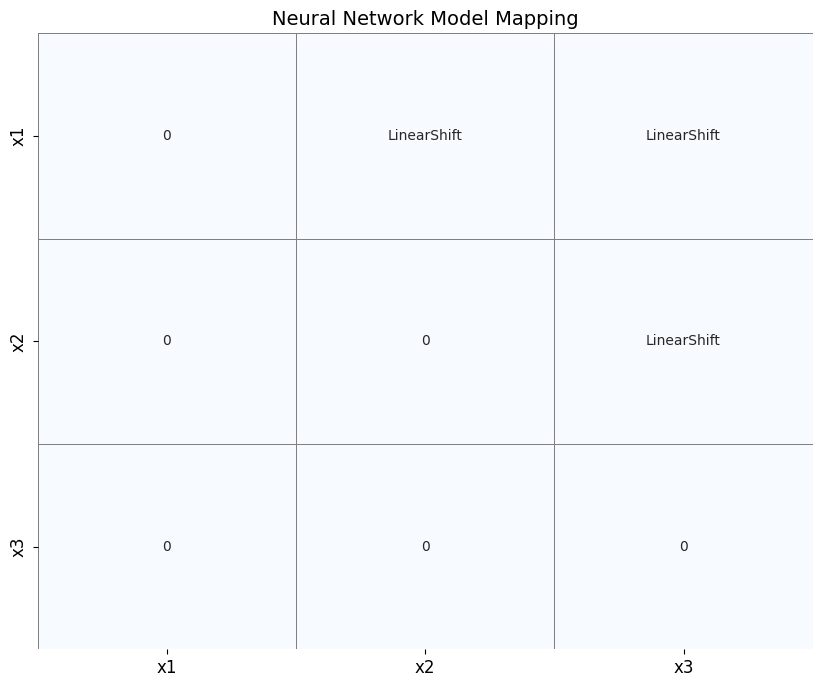

In [6]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

In [7]:
#TODO : OPTION write config to a argparser to  and args object to pass datatypes

conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
# write min max to conf dict
for i,node in enumerate(data_type.keys()):
    conf_dict[node]['min']=min_vals[i].tolist()   # <---- TODO add quanitle marker
    conf_dict[node]['max']=max_vals[i].tolist()
    

# write to file
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"{experiment_name}_conf.json")
with open(CONF_DICT_PATH, 'w') as f:
    json.dump(conf_dict, f, indent=4)
    
print(f"Configuration saved to {CONF_DICT_PATH}")

conf_dict

Configuration saved to /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_9/tramdagpaper_exp6_1_linearDGP_ls_9_conf.json


/tmp/ipykernel_1464911/1695834966.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['min']=min_vals[i].tolist()   # <---- TODO add quanitle marker
/tmp/ipykernel_1464911/1695834966.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_dict[node]['max']=max_vals[i].tolist()


{'x1': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {},
  'min': 0.12053222464687426,
  'max': 0.794692622870355},
 'x2': {'Modelnr': 1,
  'data_type': 'cont',
  'node_type': 'internal',
  'parents': ['x1'],
  'parents_datatype': {'x1': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ls'},
  'transformation_term_nn_models_in_h()': {'x1': 'LinearShift'},
  'min': -0.8142888901184293,
  'max': 0.4238437120810543},
 'x3': {'Modelnr': 2,
  'data_type': 'cont',
  'node_type': 'sink',
  'parents': ['x1', 'x2'],
  'parents_datatype': {'x1': 'cont', 'x2': 'cont'},
  'transformation_terms_in_h()': {'x1': 'ls', 'x2': 'ls'},
  'transformation_term_nn_models_in_h()': {'x1': 'LinearShift',
   'x2': 'LinearShift'},
  'min': -4.421199142423371,
  'max': 4.916709870336174}}

In [ ]:
#TODO  WARMstart with parameters from logistic regression for SI 
# glm with binomial link funciton  x2 ~ X1  , X2~ X1 +  x2  , estimate betas, set in conf dict, load to SI models as linear shift parmerte , use intercept for SI estamtion

# 4.1 Warmstart with logreg

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      8000 non-null   float64
 1   x2      8000 non-null   float64
 2   x3      8000 non-null   float64
dtypes: float64(3)
memory usage: 250.0 KB


In [35]:
train_df['x1'].to_numpy().reshape(-1, 1).shape

(8000, 1)

In [37]:
train_df['x1'].to_numpy().shape

(8000,)

In [36]:
train_df['x2'].to_numpy().reshape(-1, 1).shape

(8000, 1)

In [38]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(train_df['x1'].to_numpy().reshape(-1, 1), train_df['x2'].to_numpy().reshape(-1, 1))

/home/bule/anaconda3/envs/tramdag/lib/python3.9/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [21]:
train_df

,x1,x2,x3
9254,0.740085,-0.148391,5.284870
1561,0.692377,-0.424960,1.241708
1670,0.800302,0.312899,1.666196
6087,0.750552,-0.136315,0.920119
6669,0.700160,0.268926,3.419885
...,...,...,...
5734,0.720929,-0.575900,-4.214391
5191,0.150702,0.286169,-1.276768
5390,0.705662,-0.466566,2.346287
860,0.173100,-0.035134,-1.733285


In [15]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 1000  # <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
use_scheduler = True

In [ ]:
# For each NODE 
for node in conf_dict:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    MODEL_PATH, LAST_MODEL_PATH, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)

    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=True).to(device)

    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 4. Load Model & History ######################
    if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(MODEL_PATH))

        with open(TRAIN_HIST_PATH, 'r') as f:
            train_loss_hist = json.load(f)
        with open(VAL_HIST_PATH, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist, val_loss_hist = [], []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################.
    
    ## <---------- TODO use standard SGD and no scheduler
    optimizer = torch.optim.AdamW(tram_model.parameters(), lr=0.1, eps=1e-8, weight_decay=1e-2)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################

    if DEV_TRAINING:
        train_val_loop(
            start_epoch,
            epochs,
            tram_model,
            train_loader,
            val_loader,
            train_loss_hist,
            val_loss_hist,
            best_val_loss,
            device,
            optimizer,
            use_scheduler,
            scheduler,
            min_max,
            NODE_DIR,
            save_linear_shifts=True
        )


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 500...
Saved new best model.
Epoch 501/1000 | Train Loss: -0.5585 | Val Loss: -0.5510
  [Train: 1.06s | Val: 0.38s | Save: 0.01s | Total: 1.46s]
Saved new best model.
Epoch 502/1000 | Train Loss: -0.5684 | Val Loss: -0.5561
  [Train: 0.78s | Val: 0.33s | Save: 0.01s | Total: 1.12s]
Saved new best model.
Epoch 503/1000 | Train Loss: -0.5740 | Val Loss: -0.5565
  [Train: 0.79s | Val: 0.33s | Save: 0.01s | Total: 1.13s]
Epoch 504/1000 | Train Loss: -0.5722 | Val Loss: -0.5560
  [Train: 0.84s | Val: 0.35s | Save: 0.01s | Total: 1.20s]
Epoch 505/1000 | Train Loss: -0.5712 | Va

In [ ]:
train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=10, verbose=True)

# Assuming this is how your data looks like
data, labels = next(iter(train_loader))  # or val_loader
tensor1, tensor2, tensor3_train = data  # Unpack the three input tensors

# Plot histograms
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.hist(tensor1.numpy(), bins=20)
plt.title("Tensor 1 Histogram")

plt.subplot(1, 4, 2)
plt.hist(tensor2.numpy(), bins=20)
plt.title("Tensor 2 Histogram")

plt.subplot(1, 4, 3)
plt.hist(tensor3_train.numpy(), bins=20)
plt.title("Tensor 3 Histogram")

plt.subplot(1, 4, 4)
plt.hist(labels.numpy(), bins=20)
plt.title("Label Tensor Histogram")

plt.tight_layout()
plt.show()



# Assuming this is how your data looks like
data, labels = next(iter(val_loader))  # or val_loader
tensor1, tensor2, tensor3 = data  # Unpack the three input tensors

# Plot histograms
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.hist(tensor1.numpy(), bins=20)
plt.title("Tensor 1 Histogram")

plt.subplot(1, 4, 2)
plt.hist(tensor2.numpy(), bins=20)
plt.title("Tensor 2 Histogram")

plt.subplot(1, 4, 3)
plt.hist(tensor3.numpy(), bins=20)
plt.title("Tensor 3 Histogram")

plt.subplot(1, 4, 4)
plt.hist(labels.numpy(), bins=20)
plt.title("Label Tensor Histogram")

plt.tight_layout()
plt.show()

from statsmodels.graphics.gofplots import qqplot_2samples

qqplot_2samples(tensor3_train, tensor3, line='45')
plt.title("Q-Q Plot: tensor3 (train) vs tensor3 (val)")
plt.grid(True)
plt.show()

In [ ]:
## before normalizing with test and train quantiles

# [[tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
#   tensor([0.0737, 0.7634, 0.3469, 0.6916, 0.7227, 0.3493, 0.9001, 0.2211, 0.6545,
#           0.1304]),
#   tensor([ 3.0017, -2.0504,  1.2497, -3.6898, -6.3833, -7.1274, -1.4036,  2.1854,
#           -4.6354, -4.8516])],
#  tensor([-3.7115, -0.6047,  2.1268,  0.2091,  1.3839, -0.1416, 10.1945, -3.0409,
#           5.6472,  0.6839])]




# Train loader (x3):   0%|          | 0/800 [00:00<?, ?it/s]
# train_ints: tensor([[1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.],
#         [1.]], device='cuda:0')
# train_shifts: [tensor([[0.3784],
#         [0.2984],
#         [0.3573],
#         [0.1439],
#         [0.6348],
#         [0.2041],
#         [0.6854],
#         [0.4416],
#         [0.7309],
#         [0.0962]], device='cuda:0'), tensor([[-1.4988],
#         [-6.5330],
#         [ 3.3841],
#         [-3.9710],
#         [-4.8871],
#         [-5.0423],
#         [-5.0601],
#         [ 2.8884],
#         [-7.1315],
#         [-2.7967]], device='cuda:0')]

In [ ]:
## standardizing with train quantiles

# x_train before prp: [tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
# 
# tensor([0.2398,     0.6928,  0.1243,   0.7901,   0.7507,   0.7523,    0.0816, 0.2176,     0.2701, 0.2158]), 
# tensor([ -4.2296,   1.0713,  -9.1430,  -3.0532,  -5.5507,  -3.9975,  -0.3256, -10.6169,  -3.8768,   0.4885])]



# Val loader (x3):   0%|          | 0/1000 [00:00<?, ?it/s]
# val before prp:
# [tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 
# 
# tensor([   0.7423, 0.1869,    0.2464,  0.3020,    0.7340,  0.2072,    0.7497,  0.8257,    0.2002,   0.7113]),
# tensor([ -0.2503,  -5.5277,  -6.8035,  -7.1021,  -5.5923,  -8.1914,  -2.2981, -15.6520,   3.5235,   1.0522])]

In [ ]:
h_train_list,h_val_list=[],[]
min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
min_max = torch.stack([min_vals, max_vals], dim=0)
with torch.no_grad():
    for x, y in tqdm(train_loader, desc=f"Train loader ({node})", total=len(train_loader)):
        
        print(f'x_train before prp: {x}')
        
        y = y.to(device)
        int_input, shift_list = preprocess_inputs(x, device=device)
        
        print(f'train_ints: {int_input}')
        print(f'train_shifts: { shift_list}')
        
        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        
        
        
        h_train, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
        h_train_list.extend(h_train.cpu().numpy())
        break

In [ ]:
sns.histplot(shift_list[0].cpu().numpy())

In [ ]:
sns.histplot(shift_list[1].cpu().numpy())

In [ ]:
# train 
# x1 [0.6936, 0.6746, 0.1884, 0.7264, 0.2224, 0.7052, 0.7999, 0.2882, 0.2764,0.6748]),
# x2 -5.0963, -2.4505,  3.2266,  2.4449, -1.6755,  2.1757, -3.3529,  1.8723, -3.1236, -5.4151])]


# val
#x1 [0.8062,   0.1937, 0.8431,     0.3957,   0.7756,  0.6807,
#x2 [-9.8430,  3.1572, -10.9185,   1.9638,  -6.9769,  -1.8807,   1.0953,

In [ ]:
with torch.no_grad():
    for x, y in tqdm(val_loader, desc=f"Val loader ({node})", total=len(val_loader)):
        
        print(f'val before prp: {x}')
        y = y.to(device)
        int_input, shift_list = preprocess_inputs(x, device=device)
        
        print(f'val_ints: {int_input}')
        print(f'val_shifts: {shift_list}')

        y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        h_val, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
        h_val_list.extend(h_val.cpu().numpy())
        break

In [ ]:
sns.histplot(shift_list[0].cpu().numpy())

# 6 Inspect Training

## 6.1 Loss vs epochs

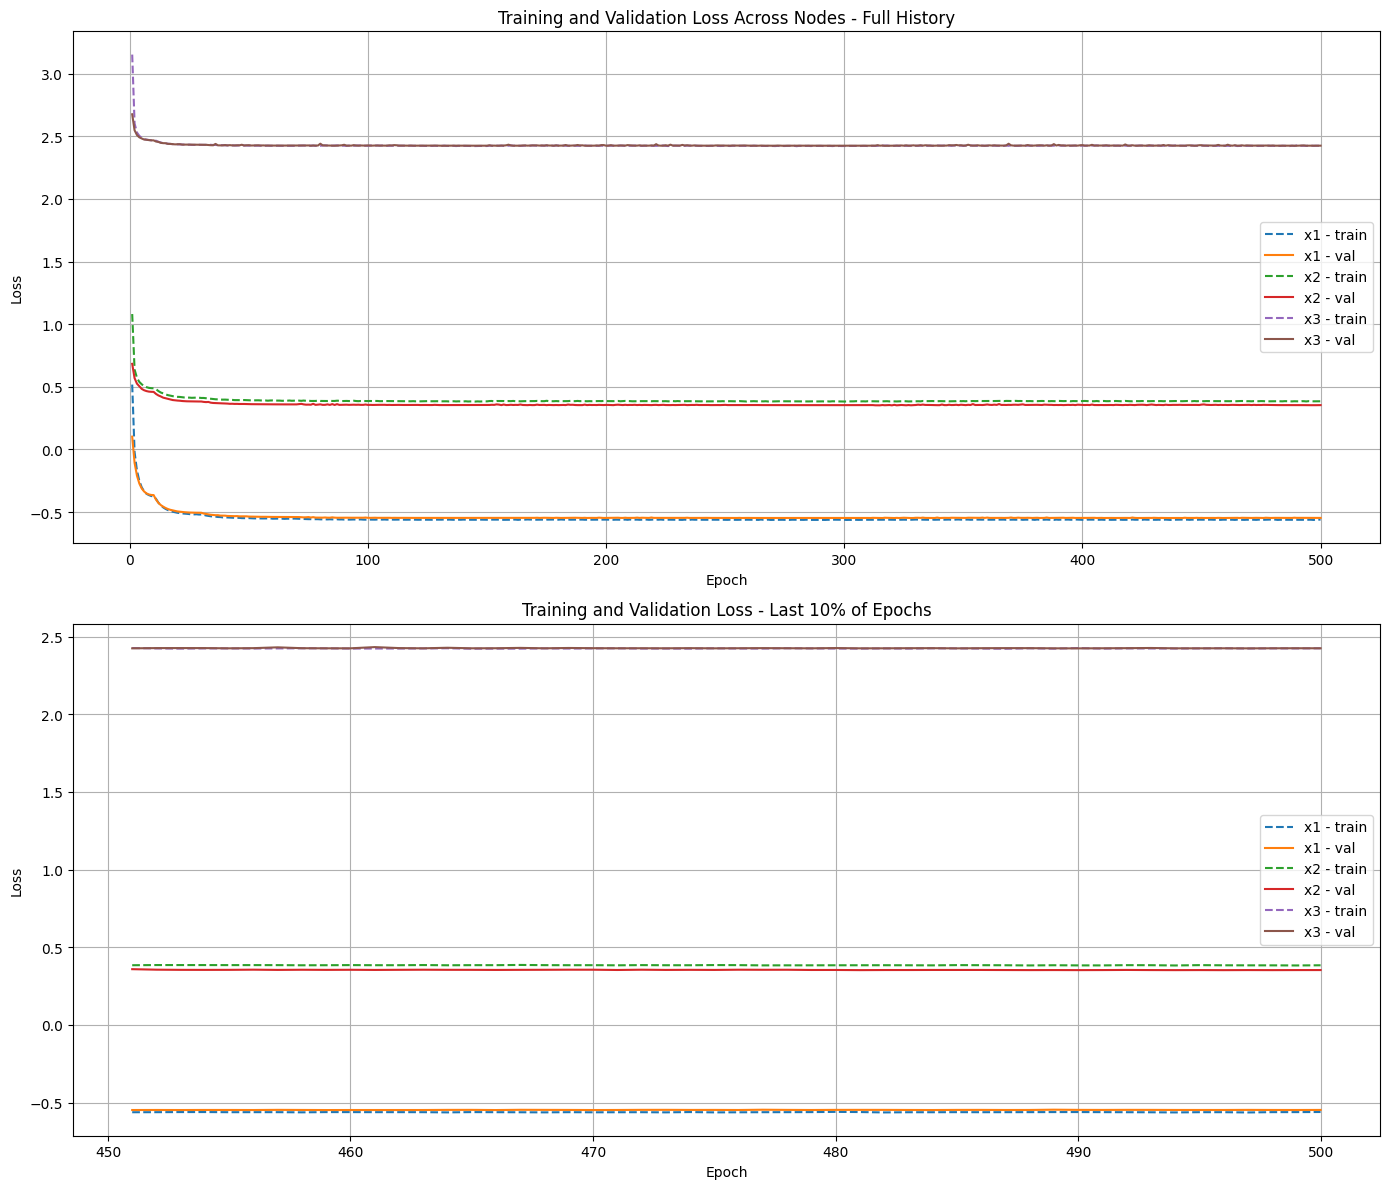

In [10]:
show_training_history(conf_dict,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


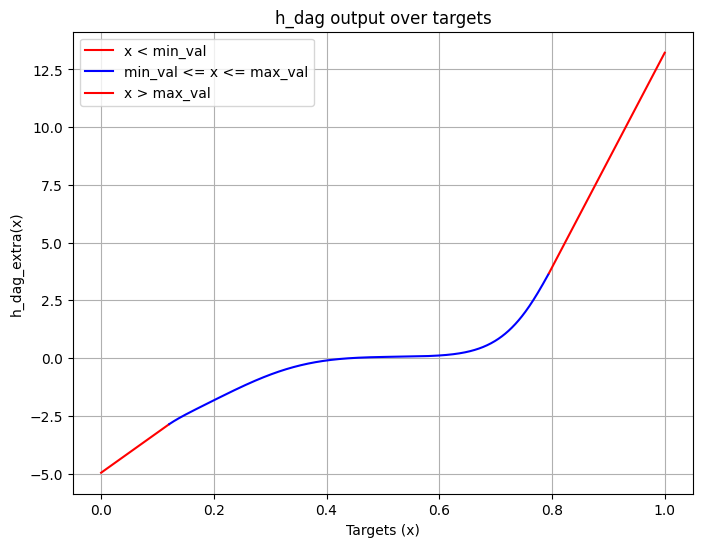


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [11]:
show_hdag_for_source_nodes(conf_dict,EXPERIMENT_DIR,device=device,xmin_plot=0,xmax_plot=1) # TODO for other nodes funciton


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


Val loader (x1): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


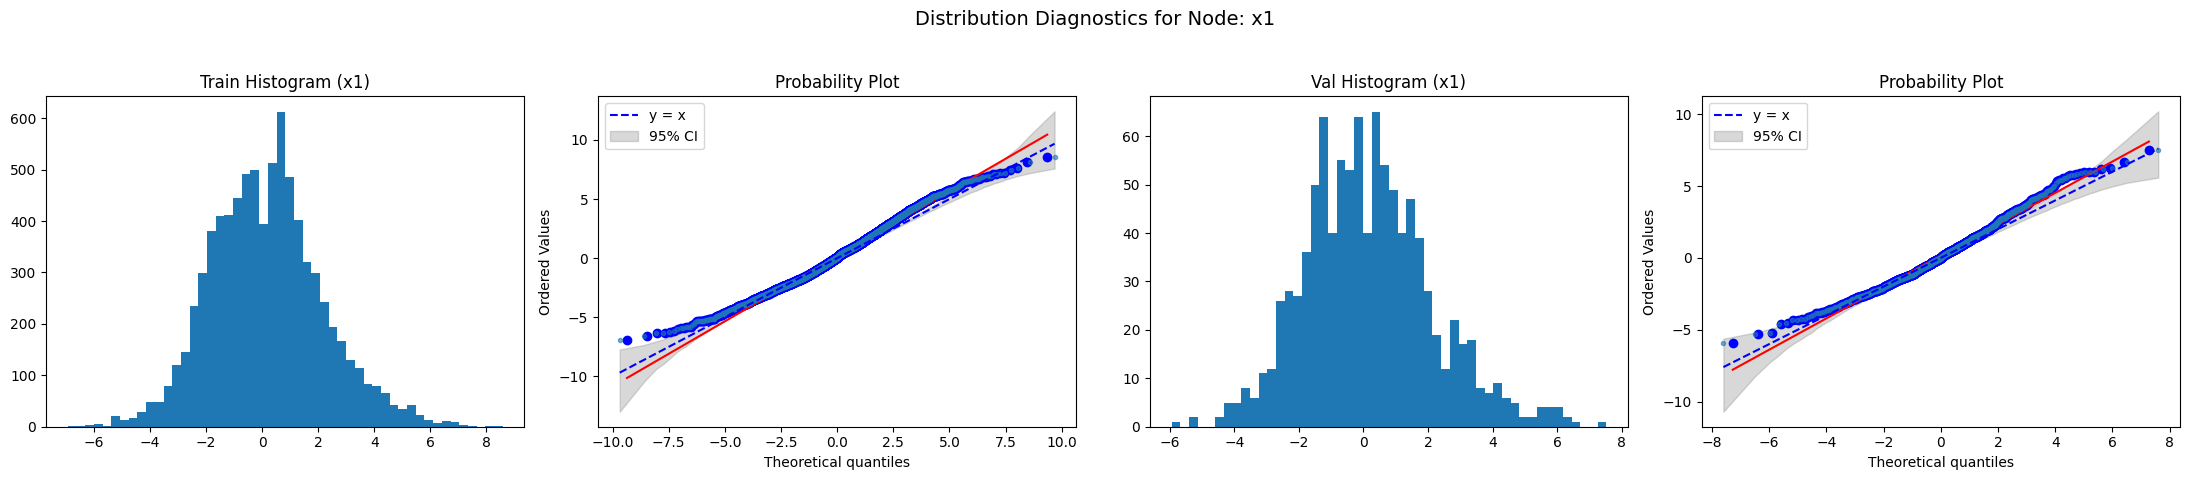


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


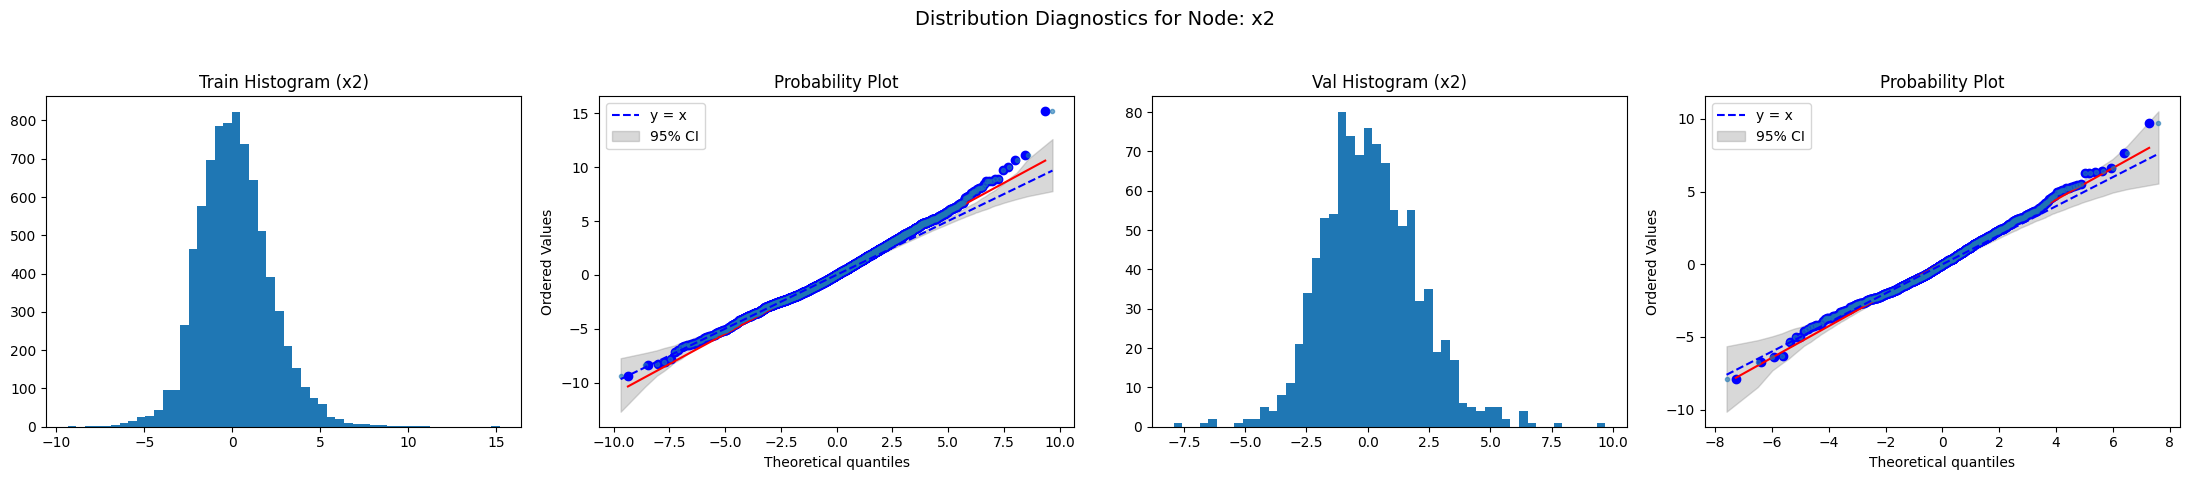


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


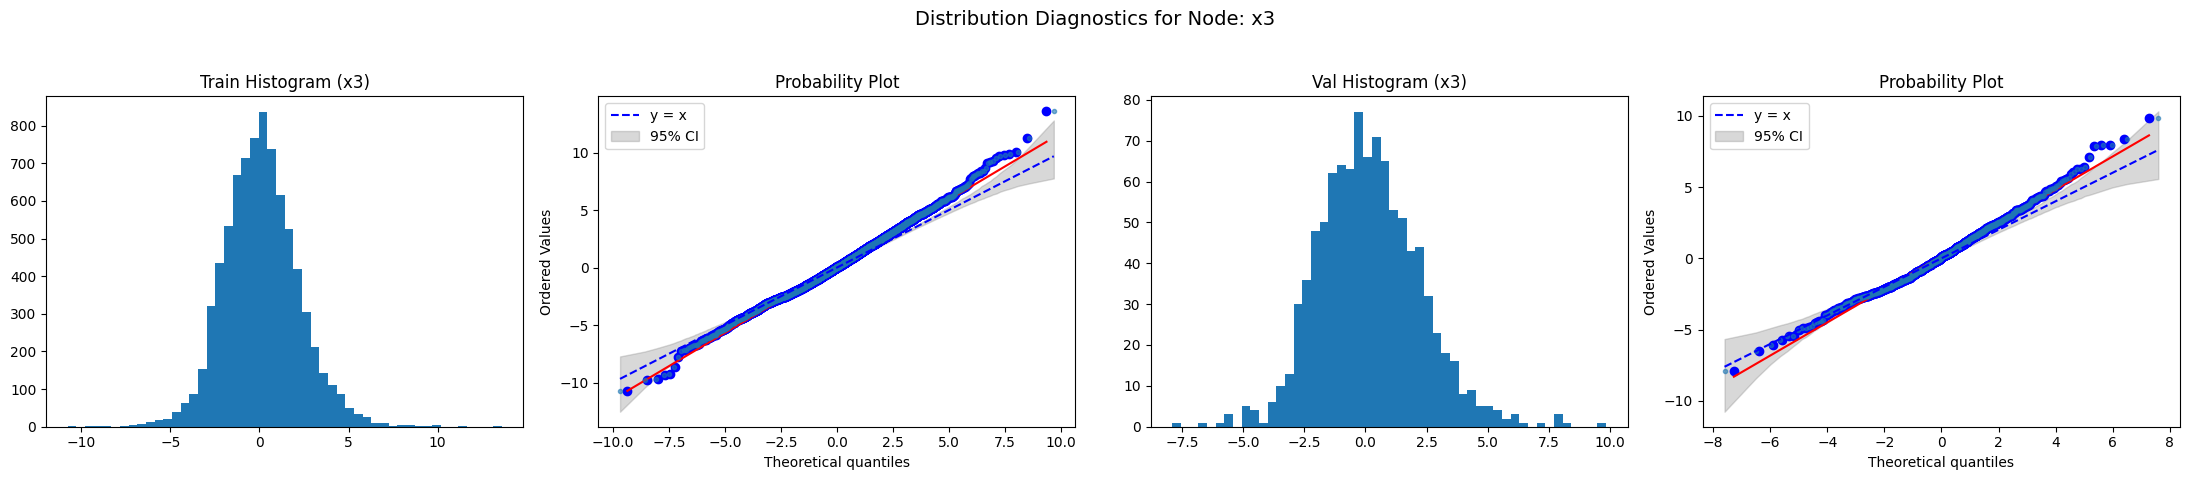

In [12]:
inspect_trafo_standart_logistic(conf_dict,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficients

In [13]:
# x1-> x2, x1-> x3, x2-> x3
true_coeffs = {'x2': [2],'x3': [-0.2, 0.3]}


----*----------*-------------*--------check CS of x1 ------------*-----------------*-------------------*--
Node type :source

----*----------*-------------*--------check CS of x2 ------------*-----------------*-------------------*--


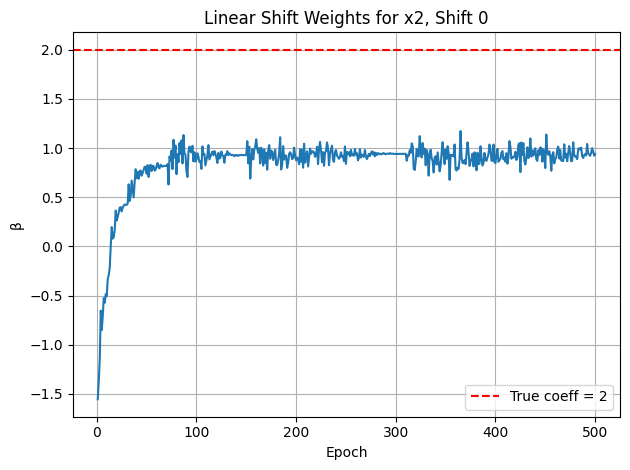


----*----------*-------------*--------check CS of x3 ------------*-----------------*-------------------*--


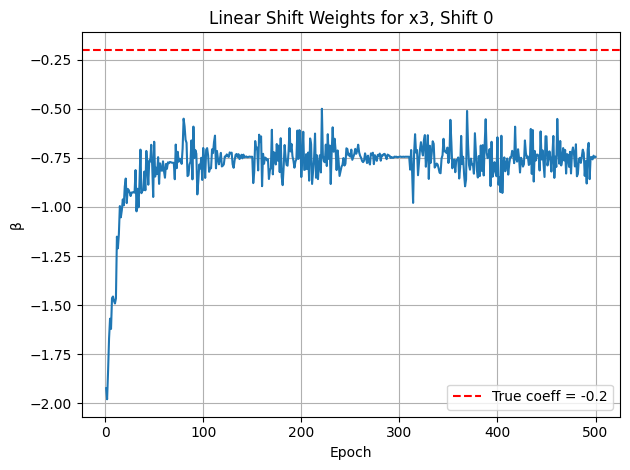

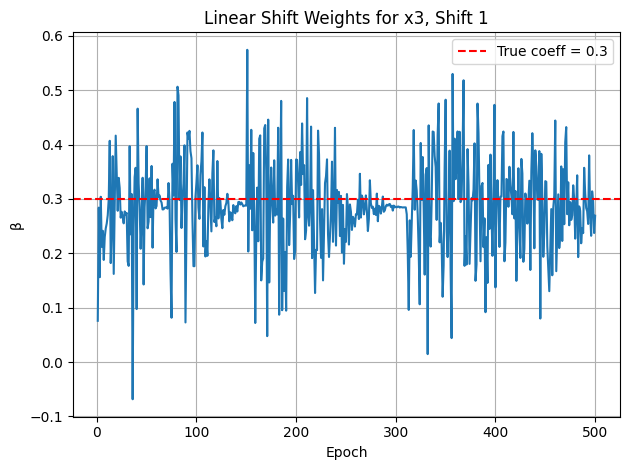

In [14]:
for node in conf_dict:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    
    if conf_dict[node]['node_type'] == 'source':
        print(f"Node type :source")
        continue
    
    # Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    # Load saved shifts
    shift_path = os.path.join(NODE_DIR, "linear_shifts_all_epochs.json")
    with open(shift_path, 'r') as f:
        all_shift_weights = json.load(f)

    # Sort epochs numerically
    epochs = sorted(all_shift_weights.keys(), key=lambda x: int(x.split('_')[1]))

    # Number of shifts (incoming edges) for this node
    example_epoch = all_shift_weights[epochs[0]]
    num_shifts = len(example_epoch)

    # Plot per shift (incoming edge)
    for shifts_idx in range(num_shifts):
        shift_name = f"shift_{shifts_idx}"
        weights_over_time = []

        for epoch in epochs:
            weight_matrix = np.array(all_shift_weights[epoch][shift_name])  # shape: [out_features, in_features]
            avg_weight = weight_matrix.mean()
            weights_over_time.append(avg_weight)

        plt.figure()
        plt.plot(range(1, len(epochs) + 1), weights_over_time)

        # If this node has a true coefficient for this shift, draw a horizontal red line
        if node in true_coeffs:
            true_val = true_coeffs[node][shifts_idx]
            plt.axhline(y=true_val, color='r', linestyle='--', label=f"True coeff = {true_val}")
            plt.legend()

        plt.title(f"Linear Shift Weights for {node}, Shift {shifts_idx}")
        plt.xlabel("Epoch")
        plt.ylabel("β")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
verbose=False


batch_size = 4112
for node in conf_dict:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    
    if (conf_dict[node]['node_type'] == 'source'):
        print(f"Node type : other , is not supported yet")
        continue
    
    
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    
    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()
    
    # for name, param in tram_model.state_dict().items():
    #     print(f"{name}: {param.data}")
        
    for i in range(len(tram_model.nn_shift)):
        print(tram_model.nn_shift[i].fc.weight.data)
    

In [ ]:
conf_dict
EXPERIMENT_DIR
train_df
val_df
device

verbose=False


batch_size = 4112
for node in conf_dict:
    print(f'\n----*----------*-------------*--------check CS of {node} ------------*-----------------*-------------------*--')
    if node != 'x2':
        print('not x2')
        continue
    #### 0. Paths
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    
    ##### 1. Load model 
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, conf_dict, verbose=verbose)
    tram_model = tram_model.to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()

    ##### 2. Dataloader
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=batch_size, verbose=verbose)
    
    #### 3. Forward Pass
    min_vals = torch.tensor(conf_dict[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(conf_dict[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    h_train_list, h_val_list = [], []
    y_pred_list=[]
    with torch.no_grad():
        print("\nProcessing training data...")
        for x, y in tqdm(train_loader, desc=f"Train loader ({node})", total=len(train_loader)):
            y = y.to(device)
            int_input, shift_list = preprocess_inputs(x, device=device)
            
            y_pred = tram_model(int_input=int_input, shift_input=shift_list)
            print(y_pred)
            print(len(shift_list[0]))
            
            break
            # for pred_entry, shift_in in zip(y_pred, shift_list):
            #     pred_entry['shift_out'] = pred_entry['shift_out'] / shift_in  # elementwise division
            #     y_pred_list.append(y_pred)
            
            # h_train, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
            # h_train_list.extend(h_train.cpu().numpy())
        # print("\nProcessing validation data...")
        # for x, y in tqdm(val_loader, desc=f"Val loader ({node})", total=len(val_loader)):
        #     y = y.to(device)
        #     int_input, shift_list = preprocess_inputs(x, device=device)
        #     y_pred = tram_model(int_input=int_input, shift_input=shift_list)
        #     h_val, _ = contram_nll(y_pred, y, min_max=min_max, return_h=True)
        #     h_val_list.extend(h_val.cpu().numpy())

# shift_outs = [entry['shift_out'][0].cpu().numpy() for entry in y_pred_list]
# shift_outs_combined = np.vstack(shift_outs)

# y_pred_list

In [ ]:
## shift betas:

In [ ]:
shift_weights = tram_model.nn_shift[0].fc.weight.data
shift_weights

In [ ]:
y_pred['shift_out'][0].cpu().numpy().squeeze().shape

In [ ]:
x[1].cpu().numpy().shape

In [ ]:
y_pred['shift_out'][0]

In [ ]:
ratio = y_pred['shift_out'][0].cpu().numpy().squeeze()  /x[1].cpu().numpy()
plt.hist(ratio, bins=1000, edgecolor='black')
plt.title('Histogram of y_pred["shift_out"][0] / x[1]')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# 7. Sample from Graph

In [15]:
n = 10_000  # Desired number of latent samples 
batch_size = 1
verbose=True
delete_all_previously_sampled=True

In [17]:
sample_full_dag_chandru(conf_dict,
                            EXPERIMENT_DIR,
                            device,
                            n= 10_000,
                            batch_size = 1,
                            delete_all_previously_sampled=False,
                            verbose=True)     


----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_std8/x1/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)


FileNotFoundError: [Errno 2] No such file or directory: '/home/bule/TramDag/dev_experiment_logs/tramdagpaper_exp6_1_linearDGP_ls_std8/x1/best_model.pt'

## 7.3 Inspect Sampling

In [ ]:
show_samples_vs_true(train_df,conf_dict,EXPERIMENT_DIR,rootfinder='chandrupatla')